from https://github.com/gSchool/dsi-solns-g55/blob/master/nlp/individual_soln.md

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression


import my_pickle as mp
import my_resample as ms

In [4]:
def mse_ridge(alpha=0.5):
    ridge = Ridge(alpha=alpha)
    fit = ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    return mean_squared_error(y_test, y_pred)


def plot_ridge():
    k = X_train.shape[1]
    alphas = np.linspace(0, 40, 1000)
    params = np.zeros((len(alphas), k))
    X_data = scale(X_train)
    for i, a in enumerate(alphas):
        fit = Ridge(alpha=a, normalize=True).fit(X_data, y_train)
        params[i] = fit.coef_

    fig = plt.figure(figsize=(14, 6))
    for param in params.T:
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(alphas, param)
    ax.set(xlabel='Alpha', ylabel='Coefficients',
                    title='Alphas vs. Beta Coefficients')
    plt.ylim(-20, 30)
    plt.show()


def test_alphas(model, alphas = np.linspace(0, 20, 400)):
    k_fold_train_error = np.zeros(len(alphas))
    k_fold_test_error = np.zeros(len(alphas))
    for i, a in enumerate(alphas):
        ridge = model(alpha=a, normalize=True)
        kf = KFold(X_train.shape[0], n_folds=10)
        train_error, test_error = KFoldCVModel(ridge, kf)
        k_fold_train_error[i] = np.mean(train_error)
        k_fold_test_error[i] = np.mean(test_error)
    return k_fold_train_error, k_fold_test_error


def KFoldCVModel(model, kf, n_folds=10):
    train_error = np.empty(n_folds)
    val_error = np.empty(n_folds)
    for i, (train, validation) in enumerate(kf):
        model.fit(X_train[train], y_train[train])
        train_error[i] = mean_squared_error(y_train[train],
                                        model.predict(X_train[train]))
        val_error[i] = mean_squared_error(y_train[validation],
                                        model.predict(X_train[validation]))
    return train_error, val_error


def plot_error():
    alphas = np.logspace(-2, 2, 200)
    k_fold_train_error, k_fold_test_error = test_alphas(Ridge, alphas)
    ridge = RidgeCV(alphas=alphas, store_cv_values=True, normalize=True)
    ridge.fit(X, y)

    fig = plt.figure(figsize=(16, 9))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(alphas, k_fold_train_error)
    ax.plot(alphas, k_fold_test_error)
    ax.vlines(alphas[k_fold_test_error.argmin()], 0, k_fold_test_error.max())
    ax.set(xlabel='Alpha', ylabel='MSE', title='Train / Validation Error')
    ax.set_xscale('log')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(alphas, ridge.cv_values_.mean(axis=0))
    ax2.set(xlabel='Alpha', ylabel='MSE', title='Learning Curve')
    ax2.set_xscale('log')
    plt.show()

    return alphas[k_fold_test_error.argmin()]


def mse_lasso(alpha=0.5):
    lasso = Lasso(alpha=alpha)
    fit = lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    return mean_squared_error(y_test, y_pred)


def plot_lasso():
    n_folds = 10
    alphas = np.linspace(0.1, 3, 200)
    params = np.zeros((len(alphas), X.shape[1]))
    X_data = scale(X_train)
    kf = KFold(X_train.shape[0], n_folds=n_folds)
    train_error = np.empty(n_folds)
    val_error = np.empty(n_folds)

    for i, a in enumerate(alphas):
        lasso = Lasso(alpha=a, normalize=True).fit(X_data, y_train)
        params[i] = lasso.coef_

        for i, (train, validation) in enumerate(kf):
            lasso.fit(X_train[train], y_train[train])
            train_error[i] = mean_squared_error(y_train[train],
                                            lasso.predict(X_train[train]))
            val_error[i] = mean_squared_error(y_train[validation],
                                            lasso.predict(X_train[validation]))

    k_fold_train_error, k_fold_test_error = test_alphas(Lasso, alphas)

    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(alphas, params)
    ax.set(xlabel='Alpha', ylabel='Coefficients',
                                        title='Alphas vs. Beta Coefficients')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(alphas, k_fold_train_error)
    ax2.plot(alphas, k_fold_test_error)
    ax2.vlines(alphas[k_fold_test_error.argmin()], 0, k_fold_test_error.max())
    ax2.set(xlabel='Alpha', ylabel='MSE', title='Alphas vs. MSE')
    ax2.set_xscale('log')
    plt.show()

    return alphas[k_fold_test_error.argmin()]


def best_choice(ridge_alpha, lasso_alpha):
    # Load entire data set
    X = diabetes.data
    y = diabetes.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    models = ['Linear Regression', 'Ridge', 'Lasso']
    model_errors = np.zeros(len(models))
    kf = KFold(X_train.shape[0], n_folds=10)
    for j, model in enumerate([LinearRegression(),
                                    Ridge(ridge_alpha), Lasso(lasso_alpha)]):
        validation = np.empty(10)
        for i, (train, test) in enumerate(kf):
            fit_model = model.fit(X_train[train], y_train[train])
            validation[i] = mean_squared_error(y_train[test],
                                            fit_model.predict(X_train[test]))
        model_errors[j] = validation.mean()

    for model, error in zip(models, model_errors):
        print (model, 'has an error of:', error)

    print ('Our best choice is', models[model_errors.argmin()])


def main():


In [6]:
X = mp.unjson_it('data_X')
y = mp.unjson_it('data_y')['response']
text_similarity_df = mp.unjson_it('data_text_similarity')
X['count_similarity'] = text_similarity_df['count_similarity']
X['tfidf_similarity'] = text_similarity_df['tfidf_similarity']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.3)

--- Part 1 ---
MSE for ridge (alpha=0.05) ->  0.0921951702201


/Users/gandalf/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/gandalf/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.375129474326474e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/Users/gandalf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique

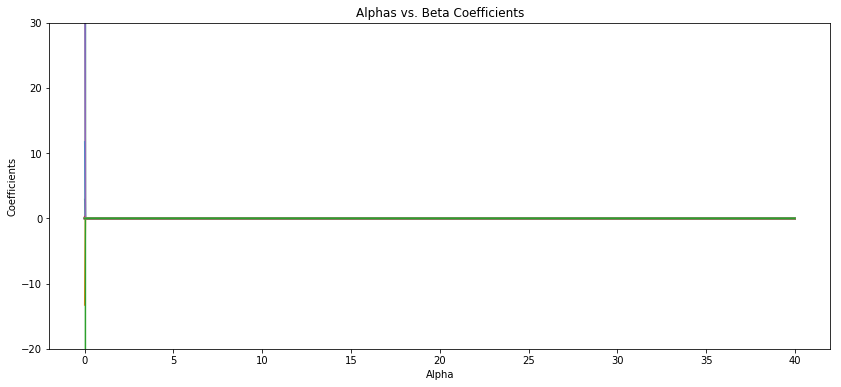

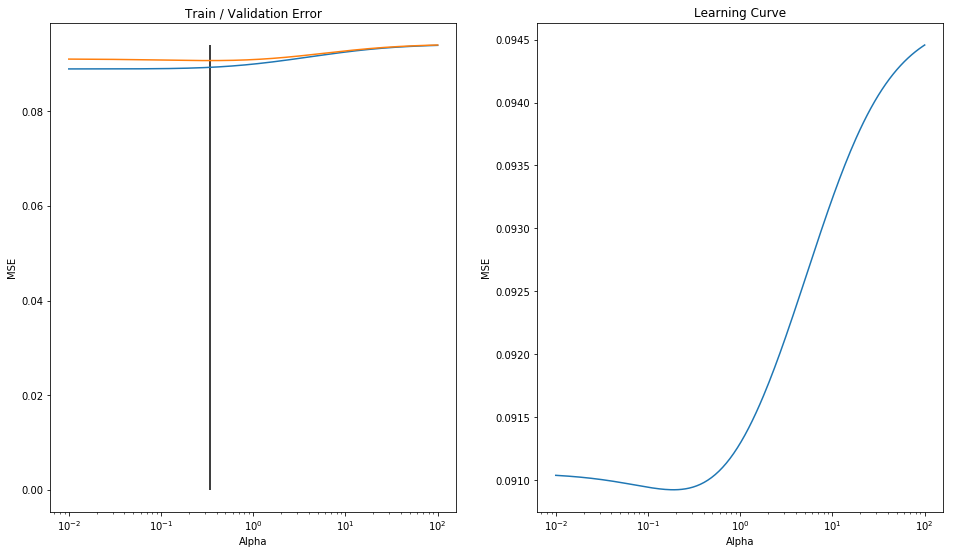

In [11]:
print ('--- Part 1 ---')
print ('MSE for ridge (alpha=0.05) -> ', mse_ridge(0.05))
plot_ridge()
ridge_alpha = plot_error()

--- Part 2 ---
MSE for lasso (alpha=0.05) ->  0.0951729609029


/Users/gandalf/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


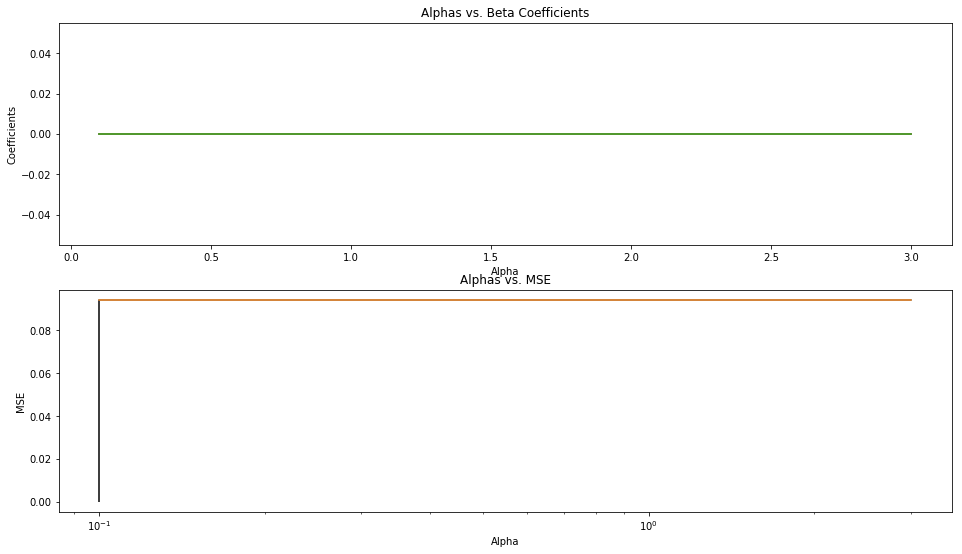

In [12]:
print ('--- Part 2 ---')
print ('MSE for lasso (alpha=0.05) -> ', mse_lasso(0.05))
lasso_alpha = plot_lasso()

In [13]:
print ('--- Part 3 ---')
best_choice(ridge_alpha, lasso_alpha)

--- Part 3 ---


NameError: name 'diabetes' is not defined